<a href="https://colab.research.google.com/github/tatianapg/abejas/blob/master/version_mf_sbn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt


In [17]:
from keras.datasets import cifar10
from keras.models import Sequential, Model
from keras.layers import Input, Dense, LeakyReLU, BatchNormalization, ReLU
from keras.layers import Conv2D, Conv2DTranspose, Reshape, Flatten
from keras.optimizers import Adam
from keras import initializers
from keras.utils import plot_model, np_utils
from keras import backend as K

In [18]:
# load dataset
(X_train, y_train), (X_test, y_test) = cifar10.load_data()


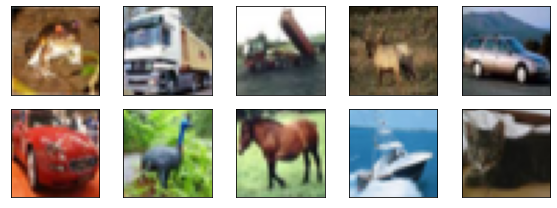

In [19]:
fig = plt.figure(figsize=(8,3))
for i in range(0, 10):
    plt.subplot(2, 5, 1 + i, xticks=[], yticks=[])
    plt.imshow(X_train[i])
    
plt.tight_layout()

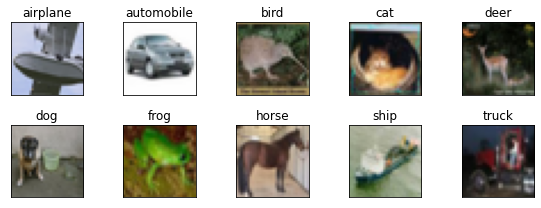

In [20]:
num_classes = len(np.unique(y_train))
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = plt.subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(y_train[:]==i)[0]
    features_idx = X_train[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    img = features_idx[img_num,::]
    ax.set_title(class_names[i])
    plt.imshow(img)
    
plt.tight_layout()

In [21]:
print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')


X_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [22]:
if K.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], 3, 32, 32)
    X_test = X_test.reshape(X_test.shape[0], 3, 32, 32)
    input_shape = (3, 32, 32)
else:
    X_train = X_train.reshape(X_train.shape[0], 32, 32, 3)
    X_test = X_test.reshape(X_test.shape[0], 32, 32, 3)
    input_shape = (32, 32, 3)
    
# convert class vectors to binary class matrices
Y_train = np_utils.to_categorical(y_train, num_classes)
Y_test = np_utils.to_categorical(y_test, num_classes)

# the generator is using tanh activation, for which we need to preprocess 
# the image data into the range between -1 and 1.

X_train = np.float32(X_train)
X_train = (X_train / 255 - 0.5) * 2
X_train = np.clip(X_train, -1, 1)

X_test = np.float32(X_test)
X_test = (X_train / 255 - 0.5) * 2
X_test = np.clip(X_test, -1, 1)

print('X_train reshape:', X_train.shape)
print('X_test reshape:', X_test.shape)

X_train reshape: (50000, 32, 32, 3)
X_test reshape: (50000, 32, 32, 3)


In [23]:
# latent space dimension
latent_dim = 100

init = initializers.RandomNormal(stddev=0.02)

# Generator network
generator = Sequential()

# FC: 2x2x512
generator.add(Dense(2*2*512, input_shape=(latent_dim,), kernel_initializer=init))
generator.add(Reshape((2, 2, 512)))
#generator.add(BatchNormalization())
generator.add(LeakyReLU(0.2))

# # Conv 1: 4x4x256
generator.add(Conv2DTranspose(256, kernel_size=5, strides=2, padding='same'))
#generator.add(BatchNormalization())
generator.add(LeakyReLU(0.2))

# Conv 2: 8x8x128
generator.add(Conv2DTranspose(128, kernel_size=5, strides=2, padding='same'))
#generator.add(BatchNormalization())
generator.add(LeakyReLU(0.2))

# Conv 3: 16x16x64
generator.add(Conv2DTranspose(64, kernel_size=5, strides=2, padding='same'))
#generator.add(BatchNormalization())
generator.add(LeakyReLU(0.2))

# Conv 4: 32x32x3
generator.add(Conv2DTranspose(3, kernel_size=5, strides=2, padding='same',
                              activation='tanh'))

In [24]:
generator.summary()


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 2048)              206848    
_________________________________________________________________
reshape_1 (Reshape)          (None, 2, 2, 512)         0         
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 2, 2, 512)         0         
_________________________________________________________________
conv2d_transpose_4 (Conv2DTr (None, 4, 4, 256)         3277056   
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 4, 4, 256)         0         
_________________________________________________________________
conv2d_transpose_5 (Conv2DTr (None, 8, 8, 128)         819328    
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 8, 8, 128)        

In [25]:
# imagem shape 32x32x3
img_shape = X_train[0].shape

# Discriminator network
discriminator = Sequential()

# Conv 1: 16x16x64
discriminator.add(Conv2D(64, kernel_size=5, strides=2, padding='same',
                         input_shape=(img_shape), kernel_initializer=init))
discriminator.add(LeakyReLU(0.2))

# Conv 2:
discriminator.add(Conv2D(128, kernel_size=5, strides=2, padding='same'))
#discriminator.add(BatchNormalization())
discriminator.add(LeakyReLU(0.2))

# Conv 3: 
discriminator.add(Conv2D(256, kernel_size=5, strides=2, padding='same'))
#discriminator.add(BatchNormalization())
discriminator.add(LeakyReLU(0.2))

# Conv 3: 
discriminator.add(Conv2D(512, kernel_size=5, strides=2, padding='same'))
#discriminator.add(BatchNormalization())
discriminator.add(LeakyReLU(0.2))

# FC
discriminator.add(Flatten())

# Output
discriminator.add(Dense(1, activation='sigmoid'))

In [26]:
discriminator.summary()


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 16, 16, 64)        4864      
_________________________________________________________________
leaky_re_lu_12 (LeakyReLU)   (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 8, 8, 128)         204928    
_________________________________________________________________
leaky_re_lu_13 (LeakyReLU)   (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 4, 4, 256)         819456    
_________________________________________________________________
leaky_re_lu_14 (LeakyReLU)   (None, 4, 4, 256)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 2, 2, 512)        

In [27]:
discriminator.compile(Adam(lr=0.0003, beta_1=0.5), loss='binary_crossentropy',
                      metrics=['binary_accuracy'])

In [28]:
# d_g = discriminador(generador(z))
discriminator.trainable = False

z = Input(shape=(latent_dim,))
img = generator(z)
decision = discriminator(img)
d_g = Model(inputs=z, outputs=decision)

d_g.compile(Adam(lr=0.0004, beta_1=0.5), loss='binary_crossentropy',
            metrics=['binary_accuracy'])



In [29]:
# prints a summary representation of your model
d_g.summary()


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
sequential_2 (Sequential)    (None, 32, 32, 3)         4512899   
_________________________________________________________________
sequential_3 (Sequential)    (None, 1)                 4308609   
Total params: 8,821,508
Trainable params: 4,512,899
Non-trainable params: 4,308,609
_________________________________________________________________


epoch = 1/100, d_loss=0.443, g_loss=3.164                                                                                                     


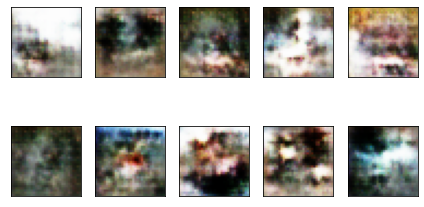

epoch = 2/100, d_loss=0.544, g_loss=2.248                                                                                                     
epoch = 3/100, d_loss=0.553, g_loss=2.216                                                                                                     
epoch = 4/100, d_loss=0.515, g_loss=2.577                                                                                                     
epoch = 5/100, d_loss=0.511, g_loss=2.534                                                                                                     
epoch = 6/100, d_loss=0.527, g_loss=2.568                                                                                                     
epoch = 7/100, d_loss=0.465, g_loss=2.860                                                                                                     
epoch = 8/100, d_loss=0.510, g_loss=2.987                                                                                                     

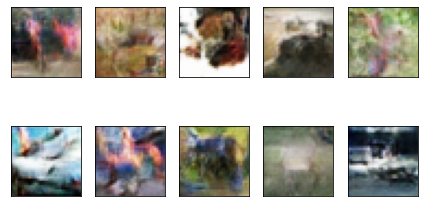

epoch = 12/100, d_loss=0.554, g_loss=3.249                                                                                                     
epoch = 13/100, d_loss=0.452, g_loss=2.660                                                                                                     
epoch = 14/100, d_loss=0.383, g_loss=3.184                                                                                                     
epoch = 15/100, d_loss=0.447, g_loss=2.967                                                                                                     
epoch = 16/100, d_loss=0.438, g_loss=3.091                                                                                                     
epoch = 17/100, d_loss=0.462, g_loss=3.263                                                                                                     
epoch = 18/100, d_loss=0.454, g_loss=3.905                                                                                              

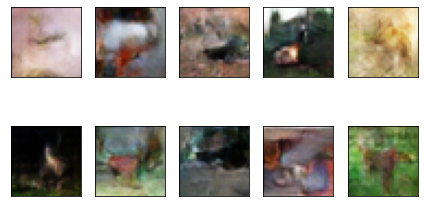

epoch = 22/100, d_loss=0.370, g_loss=3.261                                                                                                     
epoch = 23/100, d_loss=0.434, g_loss=3.932                                                                                                     
epoch = 24/100, d_loss=0.322, g_loss=3.856                                                                                                     
epoch = 25/100, d_loss=0.331, g_loss=4.443                                                                                                     
epoch = 26/100, d_loss=0.265, g_loss=4.822                                                                                                     
epoch = 27/100, d_loss=0.411, g_loss=4.377                                                                                                     
epoch = 28/100, d_loss=0.324, g_loss=4.472                                                                                              

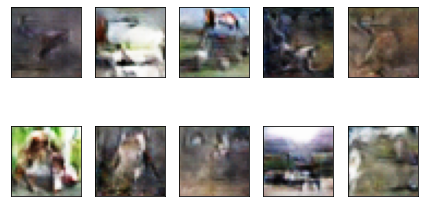

epoch = 32/100, d_loss=0.362, g_loss=2.970                                                                                                     
epoch = 33/100, d_loss=0.355, g_loss=4.318                                                                                                     
epoch = 34/100, d_loss=0.307, g_loss=5.055                                                                                                     
epoch = 35/100, d_loss=0.376, g_loss=2.877                                                                                                     
epoch = 36/100, d_loss=0.295, g_loss=4.037                                                                                                     
epoch = 37/100, d_loss=0.290, g_loss=4.197                                                                                                     
epoch = 38/100, d_loss=0.322, g_loss=4.215                                                                                              

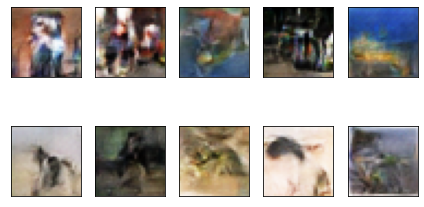

epoch = 42/100, d_loss=0.240, g_loss=4.923                                                                                                     
epoch = 43/100, d_loss=0.312, g_loss=4.445                                                                                                     
epoch = 44/100, d_loss=0.292, g_loss=5.455                                                                                                     
epoch = 45/100, d_loss=0.249, g_loss=5.859                                                                                                     
epoch = 46/100, d_loss=0.247, g_loss=6.307                                                                                                     
epoch = 47/100, d_loss=0.242, g_loss=5.846                                                                                                     
epoch = 48/100, d_loss=0.296, g_loss=4.471                                                                                              

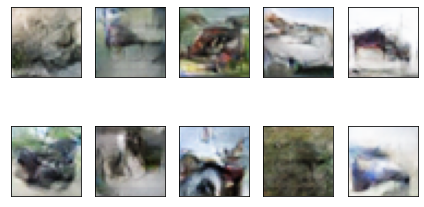

epoch = 52/100, d_loss=0.224, g_loss=5.553                                                                                                     
epoch = 53/100, d_loss=0.290, g_loss=3.801                                                                                                     
epoch = 54/100, d_loss=0.278, g_loss=4.831                                                                                                     
epoch = 55/100, d_loss=0.217, g_loss=5.665                                                                                                     
epoch = 56/100, d_loss=0.267, g_loss=4.733                                                                                                     
epoch = 57/100, d_loss=0.206, g_loss=5.665                                                                                                     
epoch = 58/100, d_loss=0.395, g_loss=3.081                                                                                              

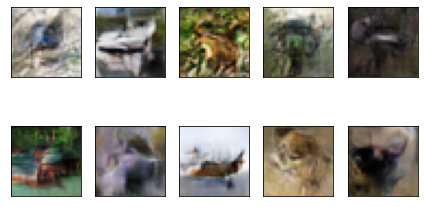

epoch = 62/100, d_loss=0.293, g_loss=6.518                                                                                                     
epoch = 63/100, d_loss=0.244, g_loss=4.890                                                                                                     
epoch = 64/100, d_loss=0.221, g_loss=5.841                                                                                                     
epoch = 65/100, d_loss=0.258, g_loss=5.484                                                                                                     
epoch = 66/100, d_loss=0.339, g_loss=5.840                                                                                                     
epoch = 67/100, d_loss=0.233, g_loss=5.599                                                                                                     
epoch = 68/100, d_loss=0.313, g_loss=5.597                                                                                              

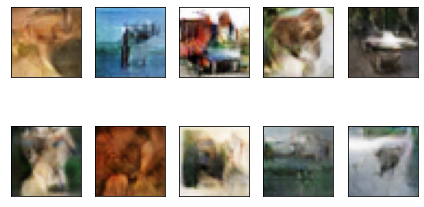

epoch = 72/100, d_loss=0.246, g_loss=5.620                                                                                                     
epoch = 73/100, d_loss=0.240, g_loss=5.705                                                                                                     
epoch = 74/100, d_loss=0.227, g_loss=6.338                                                                                                     
epoch = 75/100, d_loss=0.199, g_loss=6.355                                                                                                     
epoch = 76/100, d_loss=0.220, g_loss=6.671                                                                                                     
epoch = 77/100, d_loss=0.210, g_loss=6.224                                                                                                     
epoch = 78/100, d_loss=0.235, g_loss=4.785                                                                                              

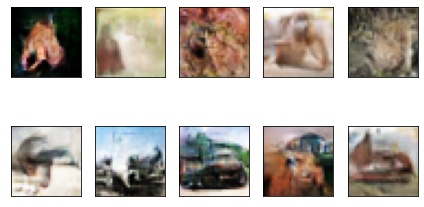

epoch = 82/100, d_loss=0.254, g_loss=4.842                                                                                                     
epoch = 83/100, d_loss=0.237, g_loss=5.246                                                                                                     
epoch = 84/100, d_loss=0.287, g_loss=6.693                                                                                                     
epoch = 85/100, d_loss=0.243, g_loss=5.558                                                                                                     
epoch = 86/100, d_loss=0.254, g_loss=5.380                                                                                                     
epoch = 87/100, d_loss=0.208, g_loss=5.074                                                                                                     
epoch = 88/100, d_loss=0.236, g_loss=6.494                                                                                              

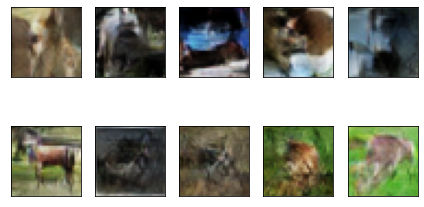

epoch = 92/100, d_loss=0.192, g_loss=5.614                                                                                                     
epoch = 93/100, d_loss=0.220, g_loss=6.953                                                                                                     
epoch = 94/100, d_loss=6.610, g_loss=45.142                                                                                                     
epoch = 95/100, d_loss=0.230, g_loss=4.862                                                                                                     
epoch = 96/100, d_loss=0.230, g_loss=4.719                                                                                                     
epoch = 97/100, d_loss=0.212, g_loss=6.633                                                                                                     
epoch = 98/100, d_loss=0.329, g_loss=2.867                                                                                             

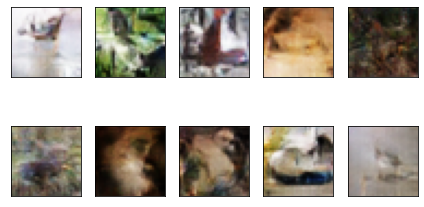

In [30]:
#1 ejecucióon tal cual estaba el codigo con 32
#2 ejecucióon tal cual estaba el codigo con 64
#3 ejecucióon tal cual estaba el codigo con 32 pero la capa Dense, una mas

epochs = 100
batch_size = 32
smooth = 0.1

real = np.ones(shape=(batch_size, 1))
fake = np.zeros(shape=(batch_size, 1))

d_loss = []
g_loss = []

for e in range(epochs + 1):
    for i in range(len(X_train) // batch_size):
        
        # Train Discriminator weights
        discriminator.trainable = True
        
        # Real samples
        X_batch = X_train[i*batch_size:(i+1)*batch_size]
        d_loss_real = discriminator.train_on_batch(x=X_batch,
                                                   y=real * (1 - smooth))
        
        # Fake Samples
        z = np.random.normal(loc=0, scale=1, size=(batch_size, latent_dim))
        X_fake = generator.predict_on_batch(z)
        d_loss_fake = discriminator.train_on_batch(x=X_fake, y=fake)
         
        # Discriminator loss
        d_loss_batch = 0.5 * (d_loss_real[0] + d_loss_fake[0])
        
        # Train Generator weights
        discriminator.trainable = False
        g_loss_batch = d_g.train_on_batch(x=z, y=real)

        print(
            'epoch = %d/%d, batch = %d/%d, d_loss=%.3f, g_loss=%.3f' % (e + 1, epochs, i, len(X_train) // batch_size, d_loss_batch, g_loss_batch[0]),
            100*' ',
            end='\r'
        )
    
    d_loss.append(d_loss_batch)
    g_loss.append(g_loss_batch[0])
    print('epoch = %d/%d, d_loss=%.3f, g_loss=%.3f' % (e + 1, epochs, d_loss[-1], g_loss[-1]), 100*' ')

    if e % 10 == 0:
        samples = 10
        x_fake = generator.predict(np.random.normal(loc=0, scale=1, size=(samples, latent_dim)))

        for k in range(samples):
            plt.subplot(2, 5, k + 1, xticks=[], yticks=[])
            plt.imshow(((x_fake[k] + 1)* 127).astype(np.uint8))

        plt.tight_layout()
        plt.show()

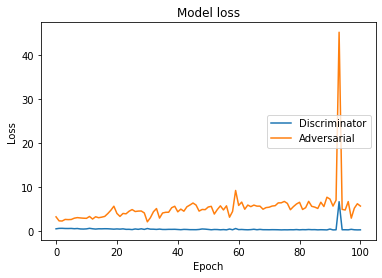

In [31]:
import matplotlib.pyplot as plt

plt.plot(d_loss)
plt.plot(g_loss)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Discriminator', 'Adversarial'], loc='center right')
plt.show()